In [20]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import psycopg2 as pg

from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import uniform
import xgboost as xgb


In [2]:
connection_args = {'host': 'localhost', 
                   'dbname': 'med_data', 
                   'port': 5432}
connection = pg.connect(**connection_args)

query = """SELECT * FROM pima"""
with open('tempfile.csv', 'wb') as tmpfile:
    copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(
       query=query, head="HEADER"
    )
    cursor = connection.cursor()
    cursor.copy_expert(copy_sql, tmpfile)
    tmpfile.seek(0)

    pima_data = pd.read_csv('tempfile.csv')

In [15]:
pima_data.head()

pregnancies  glucose  diabp  skinthickness  insulin   bmi    dpf  age  \
0            6      148     72             35        0  33.6  0.627   50   
1            1       85     66             29        0  26.6  0.351   31   
2            8      183     64              0        0  23.3  0.672   32   
3            1       89     66             23       94  28.1  0.167   21   
4            0      137     40             35      168  43.1  2.288   33   

  outcome diabetes  
0       t        t  
1       f        f  
2       t        t  
3       f        f  
4       t        t

In [16]:
outcome_series = pima_data['outcome'] == 't'
diabetes_series = pima_data['diabetes'] == 't'
pima_data['outcome'] = outcome_series
pima_data['diabetes'] = diabetes_series

In [17]:
pima_data['male'] = False

In [13]:
query = """SELECT * FROM fram"""
with open('tempfile.csv', 'wb') as tmpfile:
    copy_sql = "COPY ({query}) TO STDOUT WITH CSV {head}".format(
       query=query, head="HEADER"
    )
    cursor = connection.cursor()
    cursor.copy_expert(copy_sql, tmpfile)
    tmpfile.seek(0)

    fram_data = pd.read_csv('tempfile.csv')

In [14]:
fram_data.head()

male  age  education currentsmoker  cigsperday  bpmeds  prevalentstroke  \
0    t   39        4.0             f         0.0     0.0                0   
1    f   46        2.0             f         0.0     0.0                0   
2    t   48        1.0             t        20.0     0.0                0   
3    f   61        3.0             t        30.0     0.0                0   
4    f   46        3.0             t        23.0     0.0                0   

   prevalenthyp  diabetes  totchol  sysbp  diabp    bmi  heartrate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

  tenyearchd  
0          f  
1          f  
2          f  
3          t  
4          f

In [25]:
diabetes_series = fram_data['glucose'] >=140

diabetes_series = diabetes_series | fram_data['diabetes'] == 1

male_series = fram_data['male'] == 't'
fram_data['diabetes'] = diabetes_series
fram_data['male'] = male_series

In [53]:
columns_list = ['age', 'bmi', 'male', 'diabp', 'diabetes']
all_data = pd.concat([pima_data[columns_list], fram_data[columns_list]], ignore_index = True)
all_data.describe()

age          bmi        diabp
count  5008.000000  4989.000000  5008.000000
mean     47.074481    26.753955    80.782648
std      10.866376     5.351145    14.219447
min      21.000000     0.000000     0.000000
25%      40.000000    23.350000    73.000000
50%      47.000000    25.910000    80.000000
75%      55.000000    29.050000    88.000000
max      81.000000    67.100000   142.500000

In [54]:
all_data[['bmi', 'diabp']] = all_data[['bmi', 'diabp']].replace(0, np.nan)
all_data = all_data.dropna()


In [55]:
all_data.reset_index()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 5007
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4950 non-null   int64  
 1   bmi       4950 non-null   float64
 2   male      4950 non-null   bool   
 3   diabp     4950 non-null   float64
 4   diabetes  4950 non-null   bool   
dtypes: bool(2), float64(2), int64(1)
memory usage: 164.4 KB


In [57]:
X_train, X_test, y_train, y_test = train_test_split(all_data[['age', 'bmi', 'male', 'diabp']], all_data['diabetes'], random_state = 89)

In [58]:
featureset1 = ['age', 'bmi', 'male', 'diabetes']
featureset1X = ['age', 'bmi', 'male']
featureset2 = ['age', 'bmi', 'male', 'diabp', 'diabetes']
featureset2X = ['age', 'bmi', 'male', 'diabp']

# Testing previously built models on Framingham data
Essentially, how do the previously built models fare when confronted with very different data?

In [59]:
import pickle
pickle_in = open('linreg1.pkl', 'rb')
linreg1 = pickle.load(pickle_in)
pickle_in = open('knn1.pkl', 'rb')
knn1 = pickle.load(pickle_in)
pickle_in = open('forest1.pkl', 'rb')
forest1 = pickle.load(pickle_in)

In [62]:
eval_data = fram_data[['diabp', 'bmi', 'age', 'diabetes']].dropna()
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4221 entries, 0 to 4239
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   diabp     4221 non-null   float64
 1   bmi       4221 non-null   float64
 2   age       4221 non-null   int64  
 3   diabetes  4221 non-null   bool   
dtypes: bool(1), float64(2), int64(1)
memory usage: 136.0 KB


In [64]:
train_features = ['diabp', 'bmi', 'age']
linreg1_pred = linreg1.predict(eval_data[train_features])
linreg1_pred_proba = linreg1.predict_proba(eval_data[train_features])
print(balanced_accuracy_score(eval_data['diabetes'], linreg1_pred))

0.6005129210433344


In [65]:
linreg1_pred_proba

array([[0.54331112, 0.45668888],
       [0.39264672, 0.60735328],
       [0.42947203, 0.57052797],
       ...,
       [0.43935072, 0.56064928],
       [0.48109652, 0.51890348],
       [0.60923651, 0.39076349]])

In [67]:
knn1_pred = knn1.predict(eval_data[train_features])
print(balanced_accuracy_score(eval_data['diabetes'], knn1_pred))

0.5485594695435627


In [68]:
forest1_pred = forest1.predict(eval_data[train_features])
print(balanced_accuracy_score(eval_data['diabetes'], forest1_pred))

0.5881853667783992


# Building some logistic regressions for the app

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
X_train_1 = X_train[featureset1X]
X_train_2 = X_train[featureset2X]

vanilla_logreg1 = LogisticRegression(random_state = 65, class_weight = None)
vanilla_logreg2 = LogisticRegression(random_state = 50, class_weight = None)

vanilla_score1 = []
vanilla_score2 = []

skf = StratifiedKFold(n_splits = 5)
for train_index, val_index in skf.split(X_train, y_train):
    vanilla_logreg1.fit(X_train_1.iloc[train_index], y_train.iloc[train_index])
    vanilla_logreg2.fit(X_train_2.iloc[train_index], y_train.iloc[train_index])
    vanilla_pred1 = vanilla_logreg1.predict(X_train_1.iloc[val_index])
    vanilla_pred2 = vanilla_logreg2.predict(X_train_2.iloc[val_index])
    vanilla_score1.append(roc_auc_score(y_train.iloc[val_index], vanilla_pred1, sample_weight = None))
    vanilla_score2.append(roc_auc_score(y_train.iloc[val_index], vanilla_pred2, sample_weight = None))
print('Set 1 mean score: ', np.mean(vanilla_score1), '; set 2 mean score: ', np.mean(vanilla_score2))

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

Set 1 mean score:  0.5614380378440036 ; set 2 mean score:  0.5760845467912251


/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [76]:
1/(np.sum(all_data['diabetes'])/len(all_data['diabetes']))

11.619718309859156

In [81]:
scoring = ['recall', 'balanced_accuracy', 'roc_auc']
param_grid = {'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', None,
                               {True: 10, False: 1},
                               {True: 5, False: 1},
                               {True: 15, False: 1},
                               {True: 20, False: 1}
                              ],
              'solver': ['liblinear']
             }
rscv = RandomizedSearchCV(LogisticRegression(), param_distributions = param_grid, n_iter = 50, scoring = scoring, 
                            cv = 5, refit = 'recall', error_score=0)
search1 = rscv.fit(X_train_1, y_train)
print('Best score: ', search1.best_score_, ' using ', search1.best_params_)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922:

Best score:  0.8259436362547892  using  {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': {True: 20, False: 1}}


In [82]:
param_grid = {'penalty': ['l1', 'l2'],
              'class_weight': [{True: 20, False: 1}, 
                               {True: 30, False: 1},
                               {True: 50, False: 1},
                               {True: 75, False: 1},
                               {True: 100, False: 1}
                              ],
              'solver': ['liblinear']
             }
rscv = RandomizedSearchCV(LogisticRegression(), param_distributions = param_grid, n_iter = 50, scoring = scoring, 
                            cv = 5, refit = 'recall', error_score=0)
search1 = rscv.fit(X_train_1, y_train)
print('Best score: ', search1.best_score_, ' using ', search1.best_params_)

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score:  0.9968271072796935  using  {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': {True: 100, False: 1}}


OK, so it's possible to crank the recall up to nearly 1. Looks like I should be getting the ROC for logistic regression at various class weights so I can see which is actually the best for my purposes.

An A1C test runs in the range of 10-55USD per test. The average type II diabetic incurs approximately $10k in additional costs per year (https://www.diabetes.org/resources/statistics/cost-diabetes). Given that additional primary care provider time spend on nutritional counseling and so on could run as high as 100USD at a likely maximum (a normal visit runs about that much), our break-even point is at around 75 false positives per false negative, though this is likely overestimating costs of false positives.

In [84]:
from sklearn.metrics import confusion_matrix

weights_list = [{True: 6, False: 1}, {True: 12, False: 1}, {True:20, False: 1}, 
               {True: 40, False: 1}, {True: 60, False: 1}, 
               {True: 80, False: 1}, {True: 100, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
for i in weights_list:
    # iterate through the class_weight options
    lr = LogisticRegressionCV(penalty = 'l1', scoring = 'recall', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(X_train_1, y_train)
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(X_train_1)
    lr_conf = confusion_matrix(y_train, lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(y_train, lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
weights_results

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922

[{'weight': 6,
  'coefficients': array([[-0.01489994,  0.19215976, -0.888801  ]]),
  'recall': 0.6012658227848101,
  'false negatives': 126,
  'false positives': 330},
 {'weight': 12,
  'coefficients': array([[-0.00567618,  0.012841  ,  0.        ]]),
  'recall': 0.9177215189873418,
  'false negatives': 26,
  'false positives': 2711},
 {'weight': 20,
  'coefficients': array([[-0.00819286,  0.03301091,  0.        ]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3395},
 {'weight': 40,
  'coefficients': array([[-0.00780354,  0.0543319 ,  0.        ]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3396},
 {'weight': 60,
  'coefficients': array([[-0.0064106,  0.0651436,  0.       ]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3396},
 {'weight': 80,
  'coefficients': array([[-0.00508318,  0.07238282,  0.        ]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3396},
 {'weight': 100,
  'coefficients': array([[-0.00390512

In [85]:
weights_list = [{True: 8, False: 1}, {True: 8.5, False: 1}, {True: 9, False: 1}, 
               {True: 9.5, False: 1}, {True: 10, False: 1}, 
               {True: 10.5, False: 1}, {True: 11, False: 1}, {True: 11.5, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
for i in weights_list:
    # iterate through the class_weight options
    lr = LogisticRegressionCV(penalty = 'l1', scoring = 'recall', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(X_train_1, y_train)
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(X_train_1)
    lr_conf = confusion_matrix(y_train, lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(y_train, lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
weights_results

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922

[{'weight': 8,
  'coefficients': array([[-0.01349291,  0.19432945, -0.87511984]]),
  'recall': 0.6582278481012658,
  'false negatives': 108,
  'false positives': 435},
 {'weight': 8.5,
  'coefficients': array([[-0.02099777,  0.17179201, -0.79141281]]),
  'recall': 0.6740506329113924,
  'false negatives': 103,
  'false positives': 448},
 {'weight': 9,
  'coefficients': array([[-0.02047008,  0.17267274, -0.79115467]]),
  'recall': 0.6835443037974683,
  'false negatives': 100,
  'false positives': 494},
 {'weight': 9.5,
  'coefficients': array([[-0.01999023,  0.17342386, -0.79082239]]),
  'recall': 0.6962025316455697,
  'false negatives': 96,
  'false positives': 522},
 {'weight': 10,
  'coefficients': array([[-0.0195302 ,  0.17413177, -0.79041116]]),
  'recall': 0.7183544303797469,
  'false negatives': 89,
  'false positives': 551},
 {'weight': 10.5,
  'coefficients': array([[-0.01909104,  0.17479376, -0.7899215 ]]),
  'recall': 0.7246835443037974,
  'false negatives': 87,
  'false posit

In [86]:
weights_results = []

# iterate through the class_weight options
lr = LogisticRegressionCV(penalty = 'l1', scoring = 'recall', solver = 'liblinear', 
                          class_weight = 'balanced')
lr.fit(X_train_1, y_train)
# Essentially using this to get the scores and confusion matrix for the cross-validated model
lr_pred = lr.predict(X_train_1)
lr_conf = confusion_matrix(y_train, lr_pred)
weights_results.append({'coefficients': lr.coef_, 
                       'recall': recall_score(y_train, lr_pred), 
                       'false negatives': lr_conf[1][0], 
                       'false positives': lr_conf[0][1]})
weights_results

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922

[{'coefficients': array([[-0.02518585,  0.15728341, -0.7281338 ]]),
  'recall': 0.7310126582278481,
  'false negatives': 85,
  'false positives': 615}]

In [89]:
logreg1_final = LogisticRegressionCV(cv = 5, penalty = 'l1', scoring = 'recall', 
                                     solver = 'liblinear', max_iter = 250, 
                                     class_weight = {True: 12, False: 1})
logreg1_final.fit(all_data[featureset1X], all_data['diabetes'])
with open('logreg1.pkl', 'wb') as fp:
    pickle.dump(logreg1_final, fp)

In [101]:
all_proba = pd.DataFrame(logreg1_final.predict_proba(all_data[featureset1X]))
proba_results1 = all_proba.join(all_data['diabetes'])
proba_results1

0         1 diabetes
0     0.454208  0.545792     True
1     0.432326  0.567674    False
2     0.458370  0.541630     True
3     0.386633  0.613367    False
4     0.332666  0.667334     True
...        ...       ...      ...
4945  0.526341  0.473659    False
4946  0.531044  0.468956    False
4947  0.544678  0.455322    False
4948  0.472085  0.527915    False
4949  0.500574  0.499426    False

[4950 rows x 3 columns]

Text(0.5, 0, 'diabetes probability score')

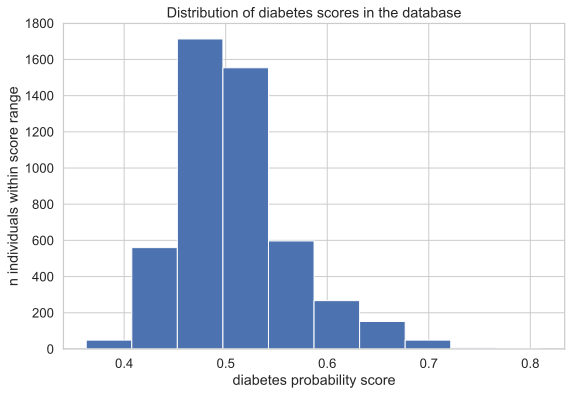

In [99]:
import matplotlib.pyplot as plt
plt.hist(proba_results.iloc[:, 1])
plt.title('Distribution of diabetes scores in the database')
plt.ylabel('n individuals within score range')
plt.xlabel('diabetes probability score')

In [100]:
weights_list = [{True: 6, False: 1}, {True: 12, False: 1}, {True:20, False: 1}, 
               {True: 40, False: 1}, {True: 60, False: 1}, 
               {True: 80, False: 1}, {True: 100, False: 1}]
# Putting together a list of dicts that I can then put into a dataframe
weights_results = []
for i in weights_list:
    # iterate through the class_weight options
    lr = LogisticRegressionCV(penalty = 'l1', scoring = 'recall', solver = 'liblinear', 
                              class_weight = i)
    lr.fit(X_train_2, y_train)
    # Essentially using this to get the scores and confusion matrix for the cross-validated model
    lr_pred = lr.predict(X_train_2)
    lr_conf = confusion_matrix(y_train, lr_pred)
    weights_results.append({'weight': i[True], 
                           'coefficients': lr.coef_, 
                           'recall': recall_score(y_train, lr_pred), 
                           'false negatives': lr_conf[1][0], 
                           'false positives': lr_conf[0][1]})
weights_results

/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change f

[{'weight': 6,
  'coefficients': array([[-0.00745365,  0.189136  , -0.65305617, -0.04034988]]),
  'recall': 0.6044303797468354,
  'false negatives': 125,
  'false positives': 315},
 {'weight': 12,
  'coefficients': array([[-0.0056762 ,  0.01284102,  0.        ,  0.        ]]),
  'recall': 0.9177215189873418,
  'false negatives': 26,
  'false positives': 2711},
 {'weight': 20,
  'coefficients': array([[-0.00777885,  0.03364422,  0.        , -0.00047629]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3395},
 {'weight': 40,
  'coefficients': array([[-0.00426077,  0.06037146,  0.        , -0.00433063]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3396},
 {'weight': 60,
  'coefficients': array([[-0.00222844,  0.07269597,  0.        , -0.00527607]]),
  'recall': 1.0,
  'false negatives': 0,
  'false positives': 3396},
 {'weight': 80,
  'coefficients': array([[-0.00080476,  0.0803957 ,  0.        , -0.00550573]]),
  'recall': 1.0,
  'false negatives': 0,
 

In [103]:
logreg2_final = LogisticRegressionCV(cv = 5, penalty = 'l1', scoring = 'recall', 
                                     solver = 'liblinear', max_iter = 250, 
                                     class_weight = {True: 12, False: 1})
logreg2_final.fit(all_data[featureset2X], all_data['diabetes'])
with open('logreg2.pkl', 'wb') as fp:
    pickle.dump(logreg2_final, fp)

In [105]:
logreg2_final.predict_proba([[18, 30, False, 100]])[0][1]

0.5600091177825243

In [106]:
pima_data.describe()

pregnancies     glucose       diabp  skinthickness     insulin  \
count   768.000000  768.000000  768.000000     768.000000  768.000000   
mean      3.845052  120.894531   69.105469      20.536458   79.799479   
std       3.369578   31.972618   19.355807      15.952218  115.244002   
min       0.000000    0.000000    0.000000       0.000000    0.000000   
25%       1.000000   99.000000   62.000000       0.000000    0.000000   
50%       3.000000  117.000000   72.000000      23.000000   30.500000   
75%       6.000000  140.250000   80.000000      32.000000  127.250000   
max      17.000000  199.000000  122.000000      99.000000  846.000000   

              bmi         dpf         age  
count  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885  
std      7.884160    0.331329   11.760232  
min      0.000000    0.078000   21.000000  
25%     27.300000    0.243750   24.000000  
50%     32.000000    0.372500   29.000000  
75%     36.600000    0.626250   41.000000  
max     67.100000    2.420000   81.000000

In [107]:
fram_data.describe()

age    education   cigsperday       bpmeds  prevalentstroke  \
count  4240.000000  4135.000000  4211.000000  4187.000000      4240.000000   
mean     49.580189     1.979444     9.005937     0.029615         0.005896   
std       8.572942     1.019791    11.922462     0.169544         0.076569   
min      32.000000     1.000000     0.000000     0.000000         0.000000   
25%      42.000000     1.000000     0.000000     0.000000         0.000000   
50%      49.000000     2.000000     0.000000     0.000000         0.000000   
75%      56.000000     3.000000    20.000000     0.000000         0.000000   
max      70.000000     4.000000    70.000000     1.000000         1.000000   

       prevalenthyp      totchol        sysbp        diabp          bmi  \
count   4240.000000  4190.000000  4240.000000  4240.000000  4221.000000   
mean       0.310613   236.699523   132.354599    82.897759    25.800801   
std        0.462799    44.591284    22.033300    11.910394     4.079840   
min        0.000000   107.000000    83.500000    48.000000    15.540000   
25%        0.000000   206.000000   117.000000    75.000000    23.070000   
50%        0.000000   234.000000   128.000000    82.000000    25.400000   
75%        1.000000   263.000000   144.000000    90.000000    28.040000   
max        1.000000   696.000000   295.000000   142.500000    56.800000   

         heartrate      glucose  
count  4239.000000  3852.000000  
mean     75.878981    81.963655  
std      12.025348    23.954335  
min      44.000000    40.000000  
25%      68.000000    71.000000  
50%      75.000000    78.000000  
75%      83.000000    87.000000  
max     143.000000   394.000000

In [111]:
import seaborn as sbn
all_data_base = all_data[['age', 'bmi', 'diabp', 'diabetes']].dropna()
sbn.pairplot(all_data_base, hue = 'diabetes')

/Users/chesh1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/chesh1/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/chesh1/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


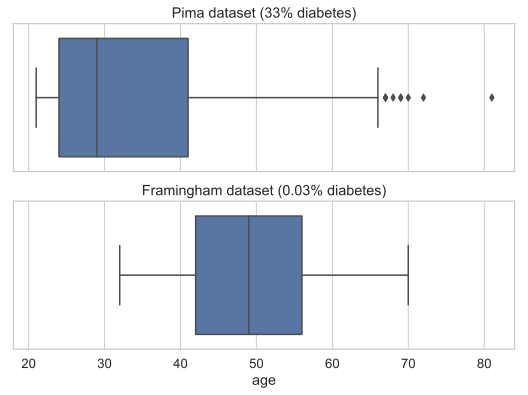

In [121]:
f, axes = plt.subplots(2, 1, sharex = True)
pima = sbn.boxplot(pima_data['age'], ax = axes[0])
axes[0].set_title('Pima dataset (33% diabetes)')
framingham = sbn.boxplot(fram_data['age'], ax = axes[1])
axes[1].set_title('Framingham dataset (0.03% diabetes)')
for ax in axes:
    ax.label_outer()